In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

In [2]:
@torch.no_grad()
def vector_moments(values, dim=1):
    mean = torch.mean(values, dim=dim)
    diffs = values - mean[:, None]
    var = torch.mean(torch.pow(diffs, 2.0), dim=dim)
    std = torch.pow(var, 0.5)
    zscore = diffs / std[:, None]
    skew = torch.mean(torch.pow(zscore, 3.0), dim=dim)
    kurt = torch.mean(torch.pow(zscore, 4.0), dim=dim)
    return mean, var, skew, kurt

@torch.no_grad()
def neuron_vocab_cosine_moments(model):
    # runs computation on whatever device model is loaded on (recommended to use mps if available)
    n_layers, d_mlp, d_vocab = model.W_out.shape[0], model.W_U.shape[1], model.W_out.shape[1]
    means, variances, skews, kurtoses = [], [], [], []

    W_U = model.W_U / model.W_U.norm(dim=0, keepdim=True)

    for i in range(n_layers):
        w_out = model.W_out[i]

        direct = w_out @ W_U
        direct = direct / w_out.norm(dim=1)[:, None]

        mean, var, skew, kurt = vector_moments(direct)

        means.append(mean)
        variances.append(var)
        skews.append(skew)
        kurtoses.append(kurt)

    # Flatten the list of numpy arrays.
    means = torch.stack(means).flatten().cpu().numpy()
    variances = torch.stack(variances, dim=0).flatten().cpu().numpy()
    skews = torch.stack(skews, dim=0).flatten().cpu().numpy()
    kurtoses = torch.stack(kurtoses, dim=0).flatten().cpu().numpy()

    n_layers, d_mlp, _ = model.W_out.shape

    neuron_moments_df = pd.DataFrame({
        'vocab_mean': means,
        'vocab_var': variances,
        'vocab_skew': skews,
        'vocab_kurt': kurtoses
    }, index=pd.MultiIndex.from_product([range(n_layers), range(d_mlp)]))
    neuron_moments_df.index.names = ['layer', 'neuron']

    return neuron_moments_df

In [3]:
#for the full list of supported models, look at https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html
model_name = "gpt2"

Loaded pretrained model gpt2 into HookedTransformer


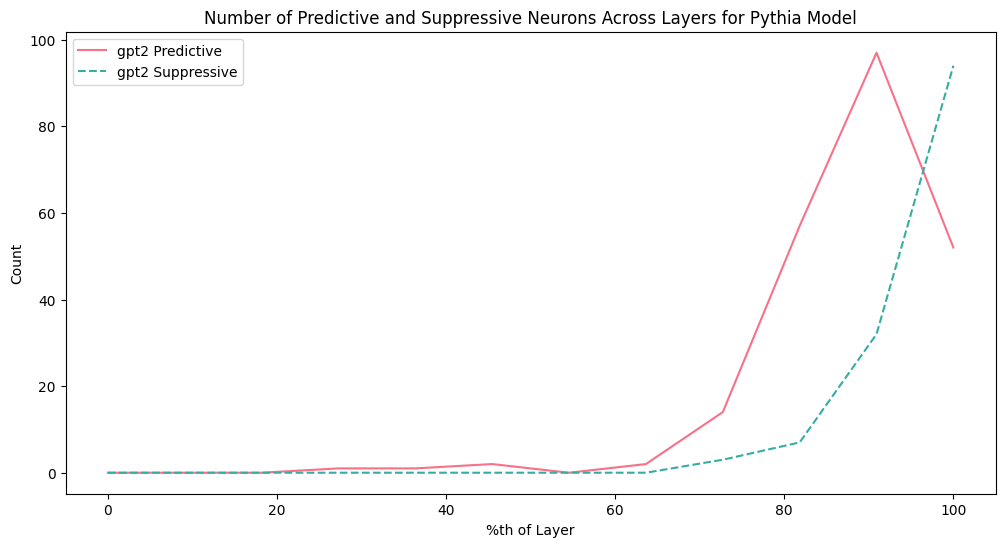

In [4]:

# Initialize the plot
plt.figure(figsize=(12, 6))

# Clear torch cache
torch.cuda.empty_cache()

# Load the model and tokenizer
hf_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token = True, use_fast=False, trust_remote_code=True)
hf_model.eval().cuda()
hooked_model = HookedTransformer.from_pretrained(model_name,
                                tokenizer=tokenizer,
                                fold_ln=True, 
                                fold_value_biases=True, 
                                center_writing_weights=True, device='cpu')

data = neuron_vocab_cosine_moments(hooked_model)

kurtosis_threshold = 10

# Add columns to identify predictive and suppressive neurons
data['is_predictive'] = (data['vocab_kurt'] > kurtosis_threshold) & (data['vocab_skew'] > 0)
data['is_suppressive'] = (data['vocab_kurt'] > kurtosis_threshold) & (data['vocab_skew'] < 0)

# Group by layer and count predictive and suppressive neurons
layer_counts = data.groupby('layer').agg({
    'is_predictive': 'sum',
    'is_suppressive': 'sum'
}).reset_index()

# Calculate percentage of layers
total_layers = layer_counts['layer'].max()
layer_counts['layer_percentage'] = (layer_counts['layer'] / total_layers) * 100

# Clean up model name for the plot label
clean_model_name = model_name.replace("-deduped", "")

# Define a color palette
colors = sns.color_palette("husl", 2)  # Only need two colors for predictive and suppressive

# Plot the results for predictive neurons
sns.lineplot(x='layer_percentage', y='is_predictive', data=layer_counts, label=f'{clean_model_name} Predictive', color=colors[0], linestyle='-')
# Plot the results for suppressive neurons
sns.lineplot(x='layer_percentage', y='is_suppressive', data=layer_counts, label=f'{clean_model_name} Suppressive', color=colors[1], linestyle='--')

# Clear GPU memory
del hf_model
del tokenizer
del hooked_model
torch.cuda.empty_cache()

# Finalize the plot
plt.xlabel('%th of Layer')
plt.ylabel('Count')
plt.title('Number of Predictive and Suppressive Neurons Across Layers for Pythia Model')
plt.legend()
plt.show()
